Цель данного проекта — изучить динамику аренд велосипедов в Лондоне на основе данных за два года (с 4 января 2015 по 3 января 2017), выявить закономерности и аномалии, а также проанализировать влияние погодных условий и выходных на количество аренд.

Задачи проекта:
	1.	Предварительная обработка данных: загрузка данных, проверка пропусков, типов данных и их корректировка.
	2.	Анализ временных рядов: построение графиков числа аренд по времени (дата и час).
	3.	Агрегация и визуализация данных: расчет и визуализация числа поездок по дням.
	4.	Скользящее среднее: расчет среднего значения с окном 3 и определение стандартного отклонения.
	5.	Аномалии: выявление аномально высоких и низких значений числа аренд и их объяснение.
	6.	Влияние факторов: изучение влияния погодных условий, выходных и праздников на динамику аренд.

Результат: Полученные выводы помогут компании лучше понимать поведение клиентов, планировать ресурсы (например, распределение велосипедов по точкам проката) и оптимизировать бизнес-процессы с учетом сезонности и влияния внешних факторов. 🚲

# Описание данных
```
timestamp – дата и время (точность до часа)
cnt – количество аренд велосипедов за этот час
t1 – температура, в С
t2 – температура "ощущается как", в С 
hum – влажность (%)
wind_speed – скорость ветра, км/ч
weather_code – погодные условия:
    1 – ясно (SKC)
    2 – преимущественно ясно / встречаются отдельные облака (SCT)
    3 – облачно / значительные облака (BKN)
    4 – пасмурно (OVC)
    7 – небольшой дождь Rain/ light Rain shower/ Light rain 
    10 – дождь с грозой
    26 – снегопад 
    94 – ледяной туман (да, такое бывает!)
isholiday – является ли день праздником (1 – праздник, 0 – нет)
isweekend – является ли день выходным (1 – выходной, 0 – нет)
season – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)
```

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import statsmodels.stats.api as sms
%matplotlib inline

In [18]:
df = pd.read_csv("../analytics/london.csv")

In [19]:
df

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [21]:
df['season'].value_counts()

0.0    4394
1.0    4387
3.0    4330
2.0    4303
Name: season, dtype: int64

In [22]:
# Метод .value_counts() показывает распределение значений в колонке 'season'.
# Вывод:
# - 0.0: весна
# - 1.0: лето
# - 2.0: осень
# - 3.0: зима

In [23]:
df['timestamp']    = pd.to_datetime(df['timestamp'])
df['weather_code'] = df['weather_code'].astype(int)
df['is_holiday']   = df['is_holiday'].astype(int)
df['is_weekend']   = df['is_weekend'].astype(int)
df['season']       = df['season'].astype(int)

In [24]:
df.sample(5)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
10556,2016-03-21 01:00:00,83,8.0,7.5,82.0,5.5,1,0,0,0
6549,2015-10-04 21:00:00,578,13.0,13.0,79.5,16.0,1,0,1,2
567,2015-01-27 16:00:00,1346,8.0,6.0,71.0,11.0,3,0,0,3
1322,2015-02-28 04:00:00,112,7.0,4.0,76.0,16.0,4,0,1,3
9675,2016-02-13 07:00:00,178,4.0,-1.0,87.0,27.0,3,0,1,3


In [25]:
df.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [26]:
df = df.set_index('timestamp')

In [27]:
# Группируем данные по дням и считаем сумму аренд велосипедов за каждый день
df_by_day = df.resample('D')['cnt'].sum().reset_index()
df_by_day.head()

,timestamp,cnt
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601


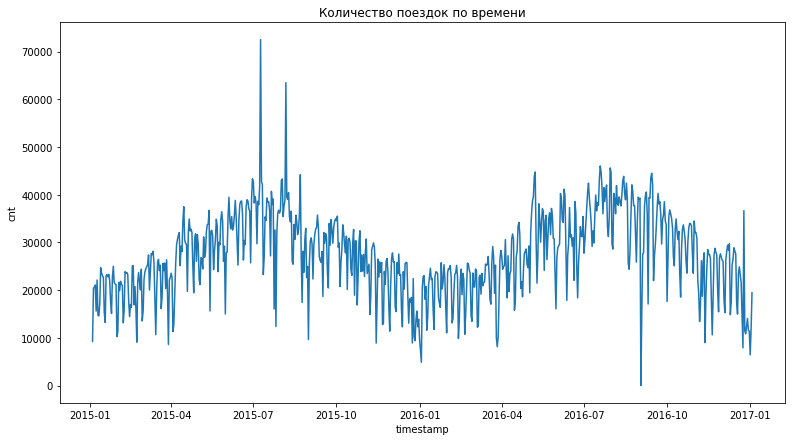

In [28]:
# Визуализируем количество поездок по времени
plt.figure(figsize=(13, 7))  # Устанавливаем размер графика
sns.lineplot(x = df_by_day['timestamp'], y = df_by_day['cnt'])  # Линейный график: дата на X, количество поездок на Y
plt.title('Количество поездок по времени')  # Заголовок графика
plt.show()

# Этот график показывает изменение количества поездок по дням.
# Видно сезонные колебания и аномальные пики.

Анализ графика:
	1.	Максимальное число аренд за день превышает 70 000, что указывает на пики спроса.
	2.	Зимой число аренд меньше, чем летом, что подтверждает сезонное влияние.
	3.	Наблюдаются резкие скачки вверх и падения, что может быть связано с праздниками или особыми событиями.
    4.  Встречаются как очень резкие скачки числа аренд, так и падения.
  

In [29]:
# Рассчитываем скользящее среднее с окном 3 дней
df_by_day_rolling = df.resample('D')['cnt'].sum().rolling(window = 3).mean().reset_index()
df_by_day_rolling.head()

,timestamp,cnt
0,2015-01-04,NaN
1,2015-01-05,NaN
2,2015-01-06,16739.666667
3,2015-01-07,20683.000000
4,2015-01-08,19092.666667


In [30]:
# Рассчитываем разницу между наблюдаемыми значениями и сглаженными значениями
df_by_day['diff'] = df_by_day['cnt'] - df_by_day_rolling['cnt']

df_by_day

,timestamp,cnt,diff
0,2015-01-04,9234,NaN
1,2015-01-05,20372,NaN
2,2015-01-06,20613,3873.333333
3,2015-01-07,21064,381.000000
4,2015-01-08,15601,-3491.666667
...,...,...,...
726,2016-12-30,11566,-1116.000000
727,2016-12-31,11424,-923.333333
728,2017-01-01,6421,-3382.666667
729,2017-01-02,11823,1933.666667


diff показывает, насколько фактическое значение отличается от тренда или усредненного значения

Сравнение фактических значений с трендом позволяет оценить стабильность данных и понять, где происходят резкие колебания.

In [32]:
std

4558.58664111794

Построим доверительный интервал для значений количества поездок (cnt), чтобы выделить аномалии, выходящие за рамки этого интервала

In [34]:
# Построение доверительного интервала (99%)
# Вычисляем стандартное отклонение наблюдаемых значений от сглаженных
std = np.std(df_by_day['cnt'] - df_by_day_rolling['cnt'])

# Определяем верхнюю границу доверительного интервала
df_by_day['upper_bound'] = df_by_day_rolling['cnt'] + (2.576 * std)

# Определяем нижнюю границу доверительного интервала
df_by_day['lower_bound'] = df_by_day_rolling['cnt'] - (2.576 * std)

df_by_day

,timestamp,cnt,diff,upper_bound,lower_bound
0,2015-01-04,9234,NaN,NaN,NaN
1,2015-01-05,20372,NaN,NaN,NaN
2,2015-01-06,20613,3873.333333,28482.585854,4996.747479
3,2015-01-07,21064,381.000000,32425.919188,8940.080812
4,2015-01-08,15601,-3491.666667,30835.585854,7349.747479
...,...,...,...,...,...
726,2016-12-30,11566,-1116.000000,24424.919188,939.080812
727,2016-12-31,11424,-923.333333,24090.252521,604.414146
728,2017-01-01,6421,-3382.666667,21546.585854,-1939.252521
729,2017-01-02,11823,1933.666667,21632.252521,-1853.585854


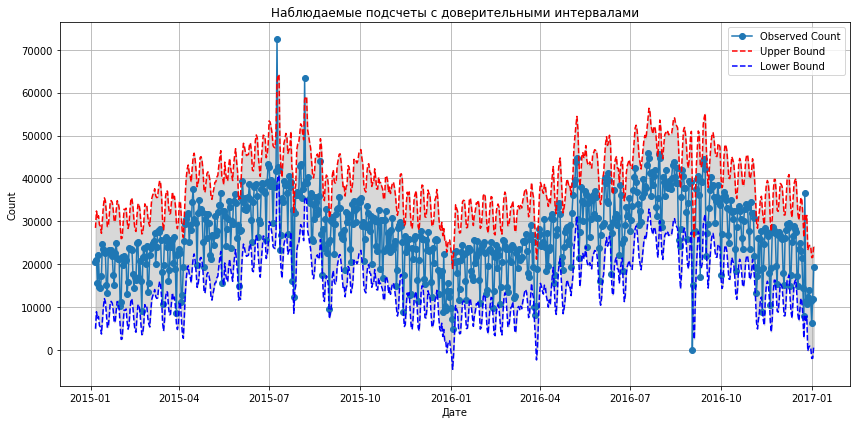

In [38]:
# Убираем None для корректной визуализации
df_by_day.dropna(inplace=True)

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(df_by_day['timestamp'], df_by_day['cnt'], label='Observed Count', marker='o')
plt.plot(df_by_day['timestamp'], df_by_day['upper_bound'], label='Upper Bound', linestyle='--', color='red')
plt.plot(df_by_day['timestamp'], df_by_day['lower_bound'], label='Lower Bound', linestyle='--', color='blue')
plt.fill_between(df_by_day['timestamp'], df_by_day['lower_bound'], df_by_day['upper_bound'], color='gray', alpha=0.3)
plt.title('Наблюдаемые подсчеты с доверительными интервалами')
plt.xlabel('Дате')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

На графике представлены наблюдаемые значения (cnt) и доверительные интервалы (99%).

		Синие точки: реальные данные за каждый день.
		Красная и синяя пунктирные линии: верхняя и нижняя границы доверительного интервала.
        
		Серый фон: диапазон нормальных значений.
		Аномалии: значения за пределами интервала выделяются и требуют дополнительного анализа (например, погодные условия, праздники или ошибки данных).


И наконец – изучим аномально высокие значения!

В какой день значение числа аренд оказалось наибольшим?

In [41]:
# Отбираем аномально высокие значения, чтобы выявить
# необычные пики спроса на аренду велосипедов

high_values = df_by_day[df_by_day['cnt'] > df_by_day['upper_bound']]
high_values

,timestamp,cnt,diff,upper_bound,lower_bound
186,2015-07-09,72504,21799.000000,62447.919188,38962.080812
214,2015-08-06,63468,16840.666667,58370.252521,34884.414146
609,2016-09-04,27512,13253.000000,26001.919188,2516.080812
721,2016-12-25,36653,17002.333333,31393.585854,7907.747479


In [42]:
# Находим день с наибольшим числом аренд.
max_rent_day = high_values.loc[high_values['cnt'].idxmax()]

# Выводим результат
print("День с наибольшим числом аренд:", max_rent_day['timestamp'])
print("Число аренд:", max_rent_day['cnt'])

День с наибольшим числом аренд: 2015-07-09 00:00:00
Число аренд: 72504


Пояснение к результату:
	1.	День с наибольшим числом аренд – 2015-07-09, когда было зафиксировано 72 504 аренды.
	2.	Причина резкого роста – забастовки в метро, что вынудило людей искать альтернативные способы
            передвижения, например, велосипеды.
            
Дата: 2015-07-09  
Причина: Информация о забастовках была найдена в новостных источниках за этот день. Это объясняет резкий рост числа аренд.

In [43]:
# Фильтруем дни с аномально низким числом аренд
low_values = df_by_day[df_by_day['cnt'] < df_by_day['lower_bound']]

# Находим день с наименьшим числом аренд
min_rent_day = low_values.loc[low_values['cnt'].idxmin()]

# Выводим результат
print("День с минимальным числом аренд:", min_rent_day['timestamp'])
print("Число аренд:", min_rent_day['cnt'])

День с минимальным числом аренд: 2016-09-02 00:00:00
Число аренд: 0


In [51]:
df.loc['2016-09-02']

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,


	Результат:
		Дата: 2016-09-02
		Причина: Ошибка при сборе данных. Это подтверждается отсутствием логических объяснений (погода, праздники или забастовки) и является типичной проблемой при технических сбоях.

Дата: 2016-09-02  
Причина: Отсутствие данных связано с техническими сбоями. Это подтверждается отсутствием влияния погоды или других факторов.

Заключение:
	1.	Аномально высокое число аренд (72 504) зафиксировано 2015-07-09. Причина — забастовки в метро, что подтверждается новостями.
	2.	Нулевое количество аренд 2016-09-02 связано с техническими сбоями. Внешние факторы исключены.
	3.	Рекомендация: внедрить систему мониторинга и проверки данных для предотвращения подобных сбоев.

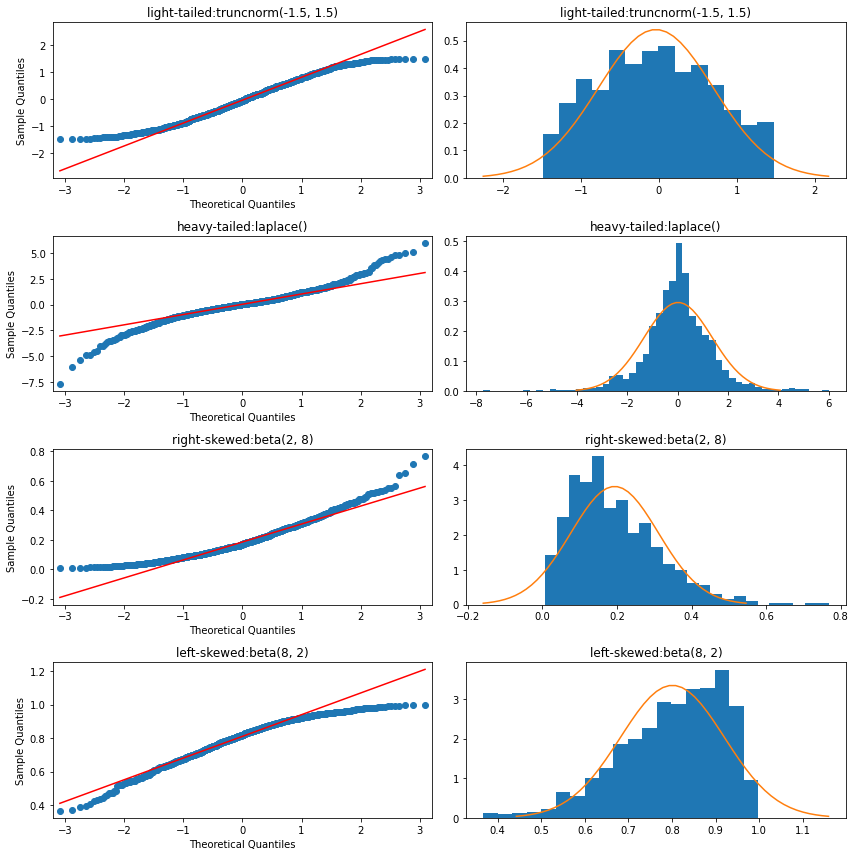

In [1]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats


N = 1000


dists = {'light-tailed':stats.truncnorm(-1.5,1.5), 'heavy-tailed':stats.laplace(), 'right-skewed':stats.beta(2,8),'left-skewed':stats.beta(8,2)}


fig,axs = plt.subplots(4,2,figsize=(12,12))
for (name, dist),(ax1,ax2) in zip(dists.items(),axs):
 x = dist.rvs(N)
 qqplot(x, line='q',ax=ax1)
 ax2.hist(x, density=True, bins='auto', histtype='stepfilled')
 normal_approx = stats.norm(loc=x.mean(),scale=x.std())
 xgrid = np.linspace(x.mean()-x.std()*3,x.mean()+x.std()*3,50)
 ax2.plot(xgrid, normal_approx.pdf(xgrid),)
 label = name + ":" + dist.dist.name + str(dist.args)
 ax1.set_title(label)
 ax2.set_title(label)


plt.tight_layout()
